In [1]:
# Import Libraries
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Train Test split
from sklearn.model_selection import train_test_split

# Feature Engineering
import feature_engine.categorical_encoders as ce
import feature_engine.missing_data_imputers as mdi
from sklearn.preprocessing import MinMaxScaler
from feature_engine.wrappers import SklearnTransformerWrapper

# Model and Metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score,recall_score

In [2]:
# Run environment Setup
import warnings
warnings.simplefilter("ignore")

# numpy print options
# used fixed dpoint notation for floats with 4 decimals
np.set_printoptions(precision=4, suppress=True, floatmode='fixed')

# Display options on terminal for pandas dataframes
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# global variables available to all functions
TRAINED_MODEL = 0
MEDIAN_IMPUTER = 0
OHCE = 0
SCALER = 0
TO_DROP = []

#### Read data

In [3]:
def read_data(filename):
    print("\n*****FUNCTION read_data*****")
    
    # Read the data file into a df
    df = pd.read_csv(os.path.join(application.config['UPLOAD_FOLDER'],filename))
    
    # See the data in the df
    print(df.head())
    
    # Full data set Shape
    print("Shape of Full set:")
    print(df.shape)
       
    return(df)
# end of function read_data

#### Data Exploration

In [4]:
def disp_df_info(df):
    print("\n*****FUNCTION disp_df_info*****")
    
    # Create a Pie Chart to check Balance
    df['Churn'].value_counts(sort=True)

    #Plotting Parameters
    plt.figure(figsize=(5,5))
    sizes = df['Churn'].value_counts(sort=True)
    colors = ["grey", 'purple']
    labels = ['No', 'Yes']

    # Plot Pie chart
    plt.pie(sizes, colors = colors, labels = labels, autopct='%1.1f%%', shadow=True, startangle=270,)
    plt.title('Percentage of Survival')
    plt.show()
    
    
    # display column Headers
    print("Column Headers:")
    print(df.columns)
          
    # print first 10 data samples
    print("Top 10 rows:")
    print(df.head(10))
    
    #Describe the df to check if features need scaling
    print("Statistics:")
    print(df.describe())
    
    # Identify the Categorical Vars and identify nulls
    print("Information:")
    print(df.info())
    
    # Count Nulls 
    print("Null Count:")
    print(df.isnull().sum())
    
    # Percent of Nulls
    print("Null Percent:") 
    print(df.isnull().mean())
    
    # Plot Histogram of TotalCharges to see distribution
    df['TotalCharges'].hist(bins=30)
    plt.title('TotalCharges Histogram')
    plt.xlabel('TotalCharges')
    plt.ylabel('Frequency/Count')
    plt.show()
    
    # Plot Histogram of tenure 
    df['Tenure'].hist(bins=30)
    plt.title('Tenure Histogram')
    plt.xlabel('Tenure')
    plt.ylabel('Frequency/Count')
    plt.show()
    
    # Plot Histogram to see distribution
    df['MonthlyCharges'].hist(bins=30)
    plt.title('MonthlyCharges Histogram')
    plt.xlabel('MonthlyCharges')
    plt.ylabel('Frequency/Count')
    plt.show()
    
# end of function disp_df_info

#### Data Cleaning

In [5]:
def data_cleaning(df_input):
    print("\n*****FUNCTION data_cleaning*****")
    
    df = df_input.copy(deep=True)
    
    # Print Shape
    print("Shape Before Dropping rows and columns:", df.shape)
    
    # Drop unwanted columns
    df.drop(['CustomerID'], axis=1, inplace=True)
    print(df.head(10))
    
    df.replace({'Churn': {'Yes': 1, 'No': 0}}, inplace=True)
    df.head()
    
    # Cast SeniorCitizen to string for OHE
    df['SeniorCitizen'] = df['SeniorCitizen'].astype(str)
    
    # Print Shape
    print("Shape After Dropping rows and columns:", df.shape) 
    
    return(df)
    # end of functiom clean_data    

#### Data Split into X/Features , Y /target , and train/test

In [6]:
def data_split(df_input):
    print("\n*****FUNCTION data_split*****")
    
    df = df_input.copy(deep=True)
    
    # Create Y var
    y = df['Churn']
    print("Y/Target Var:")
    print(y.head(10))

    # Create X var
    x = df.drop(['Churn'], axis=1)
    print("X/Feature Var:")
    print(x.head(10))
      
    # Train Test split
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 0)
    print(x_train.shape)
    print(x_test.shape)
    print(y_train.shape)
    print(y_test.shape)
    
    return(x_train, x_test, y_train, y_test)

#### Feature Engineering

In [7]:
def feature_engineering(x_train_input,x_test_input):
    print("\n*****FUNCTION feature_engineering*****")

    x_train = x_train_input.copy(deep=True)
    x_test  = x_test_input.copy(deep=True)
    
    global MEDIAN_IMPUTER
    global OHCE
       
    # Median Imputation for Age , Fare    
    MEDIAN_IMPUTER = mdi.MeanMedianImputer(imputation_method='median',
                                            variables=['TotalCharges'])
    # fit,transform x_train
    MEDIAN_IMPUTER.fit(x_train)
    x_train=MEDIAN_IMPUTER.transform(x_train)
    print(MEDIAN_IMPUTER.imputer_dict_)
    
    # transform x_test
    x_test=MEDIAN_IMPUTER.transform(x_test)
    
    # Transformed df - No Nulls after imputation
    x_train.isnull().sum() 
    
    # OHE for Categorical Vars
    OHCE=ce.OneHotCategoricalEncoder(variables=
    ['Gender','SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines','InternetService',
     'OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV',
     'StreamingMovies','Contract','PaperlessBilling','PaymentMethod'], drop_last=True)
                                                  
    # fit,transform x_train     
    OHCE.fit(x_train)
    x_train=OHCE.transform(x_train) 
    print(OHCE.encoder_dict_)

    # transform x_test
    x_test=OHCE.transform(x_test) 
    
    # Transformed x_train - dummy vars created
    print(x_train.head())
    
    # Transformed x_test - dummy vars created
    print(x_test.head())
        
    return(x_train,x_test)
# end of feature_engineering function

#### Feature Selection

In [8]:
def feature_selection(x_train_input,x_test_input):
    print("\n*****FUNCTION feature_selection*****")
    
    x_train = x_train_input.copy(deep=True)
    x_test  = x_test_input.copy(deep=True)
    
    
    global TO_DROP
    
    # Check the pearson's correlation coefficients of the variables on x_train
    corr_mat = x_train.corr()
    print(corr_mat)

    # Correlation Matrix visualized as Heatmap
    print("Correlation Martix for X/Feature Space:")
    plt.figure(figsize=(8,8))
    sns.heatmap(corr_mat, annot= True, cmap='coolwarm', center = 0 , vmin=-1, vmax=1)
    plt.show()

    #https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
    # Create correlation matrix
    corr_matrix = x_train.corr().abs()
    print(corr_matrix)
   
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    print(upper)

    # Find index of feature columns with correlation greater than a user set value 
    TO_DROP = [column for column in upper.columns if any(upper[column] > 0.80)]
    print("Features to Drop:",TO_DROP)

    # x_train Shape before dropping features
    print('x_train Shape BEFORE Dropping features:', x_train.shape)

    # Drop features on x_train
    x_train.drop(x_train[TO_DROP], axis=1, inplace=True)
    
    # x_train Shape after dropping features
    print('x_train Shape AFTER Dropping features:', x_train.shape)
    
    # x_test Shape before dropping features
    print('x_test Shape BEFORE Dropping features:', x_test.shape)
    
    # Drop features on x_test
    x_test.drop(x_test[TO_DROP], axis=1, inplace=True)
    
    # x_test Shape after dropping features
    print('x_test Shape AFTER Dropping features:', x_test.shape)
    
    return(x_train,x_test)
# end of feature_selection function

#### Feature Scaling

In [9]:
def feature_scaling(x_train_input,x_test_input):
    print("\n*****FUNCTION feature_scaling*****")

    global SCALER
    
    x_train = x_train_input.copy(deep=True)
    x_test  = x_test_input.copy(deep=True)

    SCALER = SklearnTransformerWrapper(transformer = MinMaxScaler(),
                                 variables = [ 'Tenure', 'MonthlyCharges'])
    # fit,transform x_train
    SCALER.fit(x_train)
    x_train = SCALER.transform(x_train)
    
    # transform x_test
    x_test = SCALER.transform(x_test)
    
    return(x_train,x_test)
# end of feature_scaling function

#### Model Fitting 

In [10]:
def build_logreg_model(x_train_input,x_test_input,y_train_input, y_test_input):
    print("\n*****FUNCTION build_logreg_model*****")

    x_train = x_train_input.copy(deep=True)
    x_test  = x_test_input.copy(deep=True)
    y_train = y_train_input.copy(deep=True)
    y_test  = y_test_input.copy(deep=True)
    
      
    # Call Logistic Regession with no penalty
    mod = LogisticRegression(penalty='none',random_state=0)
    mod.fit(x_train,y_train)

    # Print the Intercept and the coef
    print('Intercept:', mod.intercept_)
    print('Coefficients:', mod.coef_)
    
    # Score the model on train set
    trainscore = mod.score(x_train, y_train)
    print('Train Score:',trainscore)

    # Score the model on test set
    testscore = mod.score(x_test, y_test)
    print('Test Score:',testscore)

    # probability of being 0, 1 in binary clasification , threshold is .5
    y_prob=mod.predict_proba(x_test)
    print('Probabilities:',y_prob)
   
    # probability converted to predictions
    y_pred = mod.predict(x_test)
    print('Predictions:',y_pred)
   
    #### Model Metrics 

    # Confusion Matrix gives the mistakes made by the classifier
    cm =confusion_matrix(y_test, y_pred)
    print('Confusion Matrix:')
    print(cm)

    # Confusion Matrix visualized
    plt.figure(figsize= (8,6))
    sns.heatmap(cm, annot= True, fmt= 'd', cmap = 'Reds')
    plt.title('Confusion Matrix Visualized')
    plt.xlabel('Predicted y_pred')
    plt.ylabel('Actuals / labels - y')
    plt.show()

    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]

    # For Logistic Regression the model score is the Accuracy Ratio
    # (TP+TN)/(TP+TN+FP+FN)
    acc = accuracy_score(y_test,y_pred)
    print('Accuracy:',acc)

    # Precion = TP/(TP+FP)
    # Interpretation: out of all the predicted positive classes, how much we predicted correctly.
    pre = precision_score(y_test,y_pred)
    print('Precision:',pre)

    # Specificity = TN/(TN+FN)
    # Interpretation: out of all the -ve samples, how many was the classifier able to pick up
    spec = TN/(TN + FP)
    print('Specificity:',spec)
    
    # Recall/Sensitivity/tpr = TP/(TP+FN)
    # Interpretation: out of all the +ve samples, how many was the classifier able to pick up
    rec = recall_score(y_test,y_pred)
    tpr=rec
    print('Recall:',rec)

    # false positive rate(fpr) = FP/(FP + TN) = 1-specificity
    # Interpretation: False alarm rate
    fpr = FP/(FP + TN)
    print('False Positive Rate:',fpr)


    # Print Completion
    print('**************************** Model Ready to be used/invoked ***************************')

    # return the trained model
    return(mod,trainscore, testscore)
# end of build_logreg_model function

In [11]:
# Import Flask 
from flask import Flask
from flask import render_template
from flask import request
from flask import send_file

In [12]:
# import werkzeug to run your app as a web application
# from werkzeug.serving import run_simple

In [13]:
# Create input file folder
upload_folder_name = 'input_ibm_churn_folder'
upload_folder_path = os.path.join(os.getcwd(),upload_folder_name)
print('Upload folder path is:',upload_folder_path)
if not os.path.exists(upload_folder_path):
    os.mkdir(upload_folder_path)

Upload folder path is: C:\ANI_504_cohort_5\IBM_Telco_Churn\input_watson_churn_folder


In [14]:
# Instantiate the Flask object 
application = Flask(__name__)
print('Flask object Instantiated')

Flask object Instantiated


In [15]:
application.config['UPLOAD_FOLDER'] = upload_folder_path

In [16]:
# home displays trainform.html
@application.route("/train", methods=['GET'])
def train():
    return render_template('trainform.html')
# end of home

In [17]:
# submit on trainform.html
@application.route("/build_mod", methods=['POST'])
def build_mod():
    
    global TRAINED_MODEL
    
    file_obj = request.files.get('traindata')
    print("Type of the file is :", type(file_obj))
    name = file_obj.filename
    print(name)
    file_obj.save(os.path.join(application.config['UPLOAD_FOLDER'],name))
    
    # Is the File extension .csv
    if name.lower().endswith('.csv'):
        print('Input File extension good', name)
    else:
        print('***ERROR*** Input file extension NOT good')
        return render_template('trainform.html', errstr = "***ERROR*** Input file extension NOT good") 
    #End If
    
    # Steps to TRAIN the model
    churn_df = read_data(name)
    disp_df_info(churn_df)
    clean_df = data_cleaning(churn_df)
    x_train,x_test,y_train,y_test=data_split(clean_df)               
    x_train,x_test = feature_engineering(x_train,x_test)
    x_train,x_test = feature_selection(x_train,x_test)
    x_train,x_test = feature_scaling(x_train,x_test)
    TRAINED_MODEL,trnscore,tstscore = build_logreg_model(x_train,x_test,y_train,y_test)

    return render_template('trainresults.html',trnacc=trnscore, tstacc=tstscore)
# end of home

In [18]:
# Use model on trainresults.html
# OR Use model on predresults.html
@application.route("/use", methods=['POST','GET'])
def use():
    return render_template('predform.html')
# end of home

In [19]:
# submit on predform.html
@application.route("/make_pred", methods=['POST'])
def make_pred():
 
    file_obj = request.files.get('newdata')
    print("Type of the file is :", type(file_obj))
    name = file_obj.filename
    print(name)
    file_obj.save(os.path.join(application.config['UPLOAD_FOLDER'],name))
    
    # Is the File extension .csv
    if name.lower().endswith('.csv'):
        print('Input File extension good', name)
    else:
        print('***ERROR*** Input file extension NOT good')
        return render_template('predform.html', errstr = "***ERROR*** Input file extension NOT good") 
    #End If
    
    # Steps to USE model:
    # Call fx Read_data
    new_df = read_data(name)

    # Call fx data_cleaning
    clean_x = data_cleaning(new_df) 
    print('New Cleaned Data:')
    print(clean_x.head())
    
    # No need to split as you are ONLY getting X var from new data file
    
    # Feature Eng - Reuse the MEDIAN_IMPUTER
    print(MEDIAN_IMPUTER.imputer_dict_)
    new_x = MEDIAN_IMPUTER.transform(clean_x)
    print('New FE Data:')
    print(new_x.head())

    # Feature Eng - Reuse the OHCE
    print(OHCE.encoder_dict_)
    new_x = OHCE.transform(new_x)
    print('New FE Data:')
    print(new_x.head())

    #Feature Selection - Reuse TO_DROP
    #Drop the redundant features
    new_x.drop(new_x[TO_DROP], axis=1, inplace=True)
    print('New Selected Data:')
    print(new_x.head())

    # Feature Scale - Reuse SCALER, TO_SCALE
    new_x = SCALER.transform(new_x)

    # Make Prediction - Reuse MODEL to make prediction
    new_pred = TRAINED_MODEL.predict(new_x)
    print('New Prediction:',new_pred)

  
 #  new_pred is a np array in a row, transpose to column in order to join with original data frame
    new_pred = np.transpose(new_pred)

    # Add a new column to original data frame called 'Prediction' 
    # with the transposed new_pred np array
    new_df['Prediction']=new_pred


    # Save results to file on server without index
    new_df.to_csv(os.path.join(application.config['UPLOAD_FOLDER'],'result_'+ name),index=False)

    print("*************************** New Prediction Complete WITH FLASK ***************************************")

    # Return results to browser/client, render_template OR send_file , http does NOT allow both.
#     return render_template('predresults.html',data=new_df)
    return(send_file(os.path.join(application.config['UPLOAD_FOLDER'],'result_'+ name),as_attachment=True))


# end of make_pred

 * Running on http://localhost:8084/ (Press CTRL+C to quit)


Python script is run standalone
Python special variable __name__ = __main__


127.0.0.1 - - [11/Mar/2021 15:17:37] "GET /train HTTP/1.1" 200 -
127.0.0.1 - - [11/Mar/2021 15:17:37] "GET / HTTP/1.1" 404 -


Type of the file is : <class 'werkzeug.datastructures.FileStorage'>
watson.csv
Input File extension good watson.csv

*****FUNCTION read_data*****
   CustomerID  Gender  SeniorCitizen Partner Dependents  Tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic   

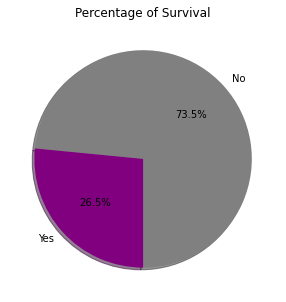

Column Headers:
Index(['CustomerID', 'Gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'Tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')
Top 10 rows:
   CustomerID  Gender  SeniorCitizen Partner Dependents  Tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   
5  9305-CDSKC  Female              0      No         No       8          Yes   
6  1452-KIOVK    Male         

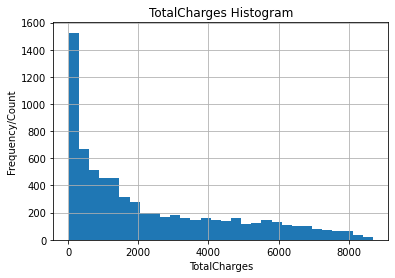

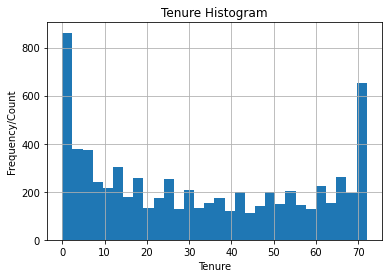

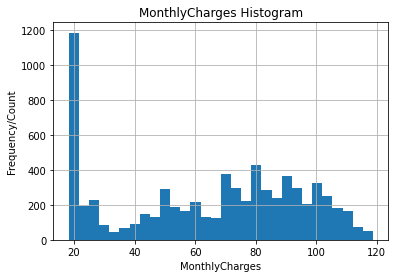


*****FUNCTION data_cleaning*****
Shape Before Dropping rows and columns: (7043, 21)
   Gender  SeniorCitizen Partner Dependents  Tenure PhoneService  \
0  Female              0     Yes         No       1           No   
1    Male              0      No         No      34          Yes   
2    Male              0      No         No       2          Yes   
3    Male              0      No         No      45           No   
4  Female              0      No         No       2          Yes   
5  Female              0      No         No       8          Yes   
6    Male              0      No        Yes      22          Yes   
7  Female              0      No         No      10           No   
8  Female              0     Yes         No      28          Yes   
9    Male              0      No        Yes      62          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             

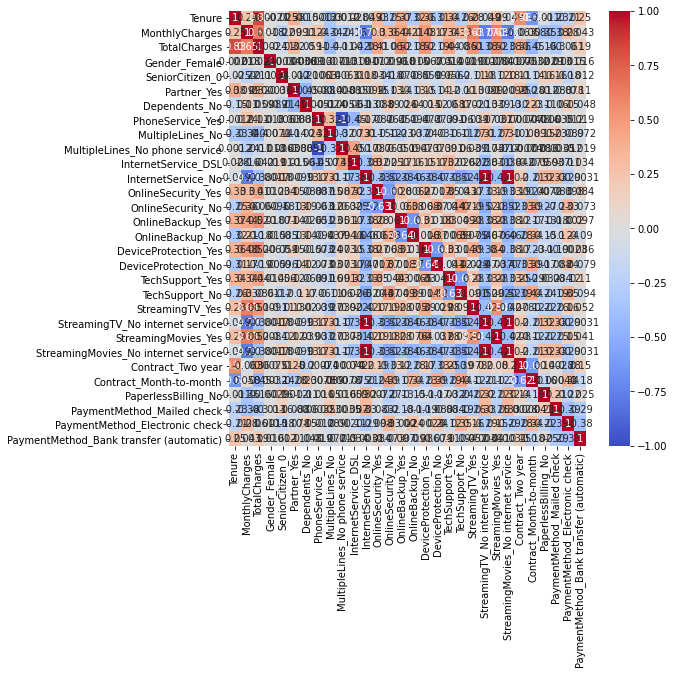

                                           Tenure  MonthlyCharges  \
Tenure                                   1.000000        0.250329   
MonthlyCharges                           0.250329        1.000000   
TotalCharges                             0.828095        0.649616   
Gender_Female                            0.002109        0.018352   
SeniorCitizen_0                          0.024983        0.221910   
Partner_Yes                              0.379471        0.098550   
Dependents_No                            0.153859        0.112570   
PhoneService_Yes                         0.001237        0.244650   
MultipleLines_No                         0.325618        0.337315   
MultipleLines_No phone service           0.001237        0.244650   
InternetService_DSL                      0.028314        0.157214   
InternetService_No                       0.049201        0.766070   
OnlineSecurity_Yes                       0.325698        0.298690   
OnlineSecurity_No                 

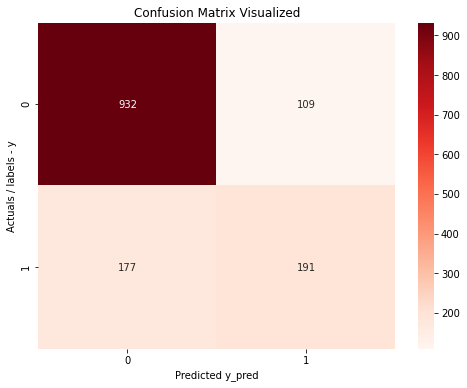

127.0.0.1 - - [11/Mar/2021 15:17:47] "POST /build_mod HTTP/1.1" 200 -


Accuracy: 0.7970191625266146
Precision: 0.6366666666666667
Specificity: 0.8952929875120077
Recall: 0.5190217391304348
False Positive Rate: 0.10470701248799232
**************************** Model Ready to be used/invoked ***************************


127.0.0.1 - - [11/Mar/2021 15:17:48] "POST /use HTTP/1.1" 200 -
127.0.0.1 - - [11/Mar/2021 15:17:54] "POST /make_pred HTTP/1.1" 200 -


Type of the file is : <class 'werkzeug.datastructures.FileStorage'>
watson_new_data1.csv
Input File extension good watson_new_data1.csv

*****FUNCTION read_data*****
  CustomerID  Gender  SeniorCitizen Partner Dependents  Tenure PhoneService  \
0  9999-AAAA    Male              1      No         No      66          Yes   
1  8888-BBBB    Male              0      No         No       1          Yes   
2  7777-CCCC  Female              0      No         No       5          Yes   
3  6666-DDDD    Male              0      No         No      10          Yes   
4  5555-EEEE  Female              1      No        Yes      56           No   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0               Yes             DSL            Yes           No   
1                No     Fiber optic             No           No   
2               Yes     Fiber optic             No          Yes   
3                No     Fiber optic             No           No   
4  No phone service     

In [ ]:
# Main Program for Web app
# If __name__ = __main__ ,program is running standalone
if __name__ == "__main__":
    print("Python script is run standalone")
    print("Python special variable __name__ =", __name__)   
        
       
    # Run the flask app in jupyter noetbook needs run_simple 
    # Run the flask app in python script needs app.run
    # run_simple('localhost',8084, app, use_debugger=True)
    application.run('0.0.0.0', debug=True)

     
else:
    # __name__ will have the name of the module that imported this script
    print("Python script was imported")
    print("Python special variable __name__ =", __name__)   
#End Main program